In [7]:
%matplotlib inline
from trimap_module import trimap
import cv2, os, sys
import numpy as np
import matplotlib.pyplot as plt

(333, 500)
2
[[ 88  88  88 ...  31  31  32]
 [ 89  89  88 ...  30  32  32]
 [ 89  89  88 ...  30  32  32]
 ...
 [211 204 200 ... 129 132 130]
 [211 206 200 ... 130 133 131]
 [210 204 199 ... 128 132 130]]


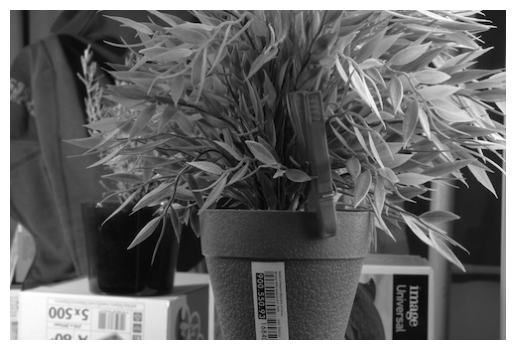

In [19]:
name    = "plant.jpg"
image     = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')
plt.axis('off')

print(image.shape)
print(len(image.shape))
print(image)

In [17]:
size = 10;         # Unknown Region Thickness
number = 000; # Obtain The Image Number (in case more than one image)
title = "binary_dilated"

height, width = image.shape[:2]
trimap(image, title, size, number)

ERROR: non-binary image (grayscale)


SystemExit: 

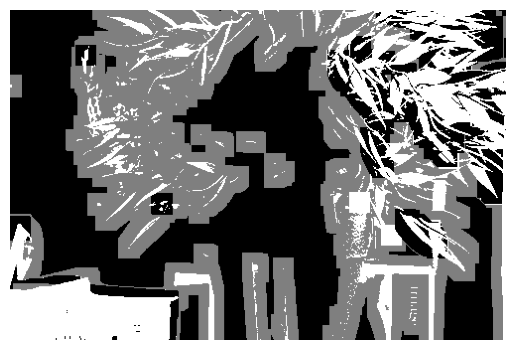

In [4]:
name  = "./images/results/10px_binary_dilated_0.png";
result = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
plt.imshow(result,cmap='gray');
plt.axis('off');

In [6]:
import numpy as np
import numpy.linalg
import scipy.sparse
import scipy.sparse.linalg
from PIL import Image
from numba import njit

def main():
    # configure paths here
    image_path  = "plant.jpg"
    trimap_path = "./images/results/10px_binary_dilated_0.png"
    alpha_path  = "cat_alpha.png"
    cutout_path = "cat_cutout.png"

    # load and convert to [0, 1] range
    image  = np.array(Image.open( image_path).convert("RGB"))/255.0
    trimap = np.array(Image.open(trimap_path).convert(  "L"))/255.0

    # make matting laplacian
    i,j,v = closed_form_laplacian(image)
    h,w = trimap.shape
    L = scipy.sparse.csr_matrix((v, (i, j)), shape=(w*h, w*h))

    # build linear system
    A, b = make_system(L, trimap)

    # solve sparse linear system
    print("solving linear system...")
    alpha = scipy.sparse.linalg.spsolve(A, b).reshape(h, w)

    # stack rgb and alpha
    cutout = np.concatenate([image, alpha[:, :, np.newaxis]], axis=2)

    # clip and convert to uint8 for PIL
    cutout = np.clip(cutout*255, 0, 255).astype(np.uint8)
    alpha  = np.clip( alpha*255, 0, 255).astype(np.uint8)

    # save and show
    Image.fromarray(alpha ).save( alpha_path)
    Image.fromarray(cutout).save(cutout_path)
    Image.fromarray(alpha ).show()
    Image.fromarray(cutout).show()

@njit
def closed_form_laplacian(image, epsilon=1e-7, r=1):
    h,w = image.shape[:2]
    window_area = (2*r + 1)**2
    n_vals = (w - 2*r)*(h - 2*r)*window_area**2
    k = 0
    # data for matting laplacian in coordinate form
    i = np.empty(n_vals, dtype=np.int32)
    j = np.empty(n_vals, dtype=np.int32)
    v = np.empty(n_vals, dtype=np.float64)

    # for each pixel of image
    for y in range(r, h - r):
        for x in range(r, w - r):

            # gather neighbors of current pixel in 3x3 window
            n = image[y-r:y+r+1, x-r:x+r+1]
            u = np.zeros(3)
            for p in range(3):
                u[p] = n[:, :, p].mean()
            c = n - u

            # calculate covariance matrix over color channels
            cov = np.zeros((3, 3))
            for p in range(3):
                for q in range(3):
                    cov[p, q] = np.mean(c[:, :, p]*c[:, :, q])

            # calculate inverse covariance of window
            inv_cov = np.linalg.inv(cov + epsilon/window_area * np.eye(3))

            # for each pair ((xi, yi), (xj, yj)) in a 3x3 window
            for dyi in range(2*r + 1):
                for dxi in range(2*r + 1):
                    for dyj in range(2*r + 1):
                        for dxj in range(2*r + 1):
                            i[k] = (x + dxi - r) + (y + dyi - r)*w
                            j[k] = (x + dxj - r) + (y + dyj - r)*w
                            temp = c[dyi, dxi].dot(inv_cov).dot(c[dyj, dxj])
                            v[k] = (1.0 if (i[k] == j[k]) else 0.0) - (1 + temp)/window_area
                            k += 1
        print("generating matting laplacian", y - r + 1, "/", h - 2*r)

    return i, j, v

def make_system(L, trimap, constraint_factor=100.0):
    # split trimap into foreground, background, known and unknown masks
    is_fg = (trimap > 0.9).flatten()
    is_bg = (trimap < 0.1).flatten()
    is_known = is_fg | is_bg
    is_unknown = ~is_known

    # diagonal matrix to constrain known alpha values
    d = is_known.astype(np.float64)
    D = scipy.sparse.diags(d)

    # combine constraints and graph laplacian
    A = constraint_factor*D + L
    # constrained values of known alpha values
    b = constraint_factor*is_fg.astype(np.float64)

    return A, b

if __name__ == "__main__":
    main()

generating matting laplacian 1 / 331
generating matting laplacian 2 / 331
generating matting laplacian 3 / 331
generating matting laplacian 4 / 331
generating matting laplacian 5 / 331
generating matting laplacian 6 / 331
generating matting laplacian 7 / 331
generating matting laplacian 8 / 331
generating matting laplacian 9 / 331
generating matting laplacian 10 / 331
generating matting laplacian 11 / 331
generating matting laplacian 12 / 331
generating matting laplacian 13 / 331
generating matting laplacian 14 / 331
generating matting laplacian 15 / 331
generating matting laplacian 16 / 331
generating matting laplacian 17 / 331
generating matting laplacian 18 / 331
generating matting laplacian 19 / 331
generating matting laplacian 20 / 331
generating matting laplacian 21 / 331
generating matting laplacian 22 / 331
generating matting laplacian 23 / 331
generating matting laplacian 24 / 331
generating matting laplacian 25 / 331
generating matting laplacian 26 / 331
generating matting la